# Example: Binomial Lattice Simulation of Equity Share Price using Real-World Probabilities
A binomial lattice model assumes that at each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.svg" width="280"/>
    </center>
</div>

while each level (time slice) of the tree is described by a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in our historical dataset.  

## Learning objectives
The objective of this example is to familiarize students with applying simple probability mass functions to predict future uncertain quantities such as commodity prices, equity share prices, interest rates, etc.

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`.
* __Objective 1__: Test the lattice model implementation using an example from `Hull`
    * `Check`: Do we reproduce the `Hull` tree values?
* __Objective 2__: Objective 2: Estimate the `up,` `down,` and probability of an up move `p` for a random firm, and simulate the share future price
  * `TODO`: Estimate the `u`, `d`, and probability `p` parameters from the historical data
  * `TODO`: Build binomial lattice model using historical $(u,d,p)$ parameters, simulate future share price
      * `Check`: Visualize price distribution at tree level `L`
  * `TODO`: Visualize the binomial lattice simulation
  * `Check`: Was this a successful simulation?

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality.

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the lattice model simulation of equity share prices:

The `MyBinomialEquityPriceTree` encodes the lattice model and has the fields:
    
* The `connectivity::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds the indexes of the children for each parent node of the tree.
* The `levels::Union{Nothing, Dict{Int64,Array{Int64,1}}}` field holds indexes of nodes that belong to each level of the tree, i.e., a trading day.
* The `u::Float64` field holds the value of the `up` factor
* The `d::Float64` field holds the value of the `down` factor
* The `p::Float64` field holds the value of the probability of an `up` move.
* The `data::Union{Nothing, Dict{Int64, MyBiomialLatticeEquityNodeModel}}` holds each node in the tree; nodes are of type `MyBiomialLatticeEquityNodeModel`

Each node in the tree is a `MyBiomialLatticeEquityNodeModel` type which has two important fields:
* The `price::Float64` field holds the price value for a node
* The `probability::Float64` field holds the probability value associated with this node

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`MyPortfolioDataSet() |> x-> x["dataset"] -> DataFrame` 
 > This function loads historical share price data. The historical share price data is returned to the caller as a Dictionary of [DataFrames](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`. The `keys` of the Dictionary are `firm_id` values.
 
`function analyze(R::Array{Float64,1};  Δt::Float64 = (1.0/252.0)) -> Tuple{Float64,Float64,Float64}`
> The `analyze(...)` function takes an array of logarithmic return values in the `R` argument and a value of the time-step size of the simulation in the $\Delta{t}$ parameter (default value of 1-day) and returns estimated values for the lattice model parameters $(u,d,p)$.  
`function build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple) -> MyBinomialEquityPriceTree` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(u,d,p)$ values) and returns an instance of the `MyBinomialEquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). Note: the `MyBinomialEquityPriceTree` returned from the `build(...)` function does not have price or probability information computed yet. Call the `populate(…)` function to populate this data.

`function populate(model::MyBinomialEquityPriceTree, Sₒ::Float64, h::Int) -> MyBinomialEquityPriceTree`
> The `populate(...)` function takes the `model::MyBinomialEquityPriceTree` instance returned from `build(...)`, a starting share price $S_{o}$ and the height of the tree, i.e., the number of time steps to simulate, and returns an updated `model::MyBinomialEquityPriceTree` instance with the price and probabilities computed for each node in the tree.

In [6]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-4/L4b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2

### Constants

In [8]:
TSIM = 21; # number of trading days to simulate
Δt = (1.0/252); # step size: 1-trading day in units of years

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [10]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [12]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [14]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [16]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

## Objective 1: Test the lattice model using an example from `Hull`
Let’s start by calculating the hypothetical share price from an example (reproduced from Chapter 13 of Hull) before diving into historical data analysis. The lattice in this example has three levels (`L=0,1,2`), with an initial share price of $S_{\circ}=20.0$ USD. An `up` move has a probability of `p = 0.6523` and a magnitude of `u = 1.1`, while a `down` move has a magnitude of `d = 0.9`.

* Calculating the future share price with a binomial lattice requires setting the model’s parameters, including the initial share price (as a `Float64`), the number of time steps to simulate into the future, which equals the number levels of the tree starting from zero (as an `Int64`), the up and down move magnitudes (as `Float64` values), and the probability of an up move (as a `Float64`):

In [18]:
Sₒ,T,u,d,p = 20.0,2,1.1,0.9,0.6523;

Once these values are set, we use the `build(…)` function to create an empty lattice model of type `MyBinomialEquityPriceTree`, which is then passed to the `populate(…)` function using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>`. 
* The `populate(…)` function calculates the prices and probabilities of each node, which are of type `MyBiomialLatticeEquityNodeModel`, in the tree:

In [20]:
test_hull_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ = Sₒ, h = T));

### Check: Do we reproduce the `Hull` tree values?
Finally, we can compare the price values we calculated to those reported by `Hull.` First, we populate the `hull_price_dictionary` dictionary, which holds `key=>value` pairs encoding the data for each node in the tree. In this dictionary, the `keys` are the node indices, while the `values` in the dictionary are the price values at that node:

In [22]:
hull_price_dictionary = Dict(0=>20.0, 1=>22.0,2=>18.0,3=>24.2,4=>19.8,5=>16.2);

Now, let's populate `hull_test_data_table`, which is of type `DataFrame`, and display the contents using the `pretty_table(...)` function, exported by [PrettyTable.jl package](https://github.com/ronisbr/PrettyTables.jl) using a `for` loop. For iteration of the `for` loop:
* We capture the node index `i`, the share price from `Hull`, and our computed price at that node from the binomial tree
* We use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox), with a relative tolerance `rtol = 1e-4`, to check if our computed price aggress with the price reported by `Hull.` If yes, a value of `true` is reported, otherwise `false`

In [24]:
number_of_nodes = length(test_hull_model.data);
hull_test_data_table = DataFrame();
for i ∈ 0:(number_of_nodes-1)
    
    row_data = (
        node = i,
        hull_price = hull_price_dictionary[i],
        our_price =  test_hull_model.data[i].price, 
        isapproxequal = isapprox(hull_price_dictionary[i], test_hull_model.data[i].price, rtol=1e-4)
    );
    
    push!(hull_test_data_table, row_data)
end
pretty_table(hull_test_data_table, tf=tf_simple)

======== ============ =========== ================
   node   hull_price   our_price   isapproxequal 
  Int64      Float64     Float64            Bool 
======== ============ =========== ================
      0         20.0        20.0            true
      1         22.0        22.0            true
      2         18.0        18.0            true
      3         24.2        24.2            true
      4         19.8        19.8            true
      5         16.2        16.2            true
======== ============ =========== ================


## Objective 2: Estimate the `up,` `down,` and probability of an up move `p` for a random firm, and simulate the future share price
After validating our lattice implementation, it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we must estimate three critical parameters: $p$, $u$, and $d$.

* The $p$ parameter represents the probability of a share price increase or an `up` move between two periods $j\rightarrow{j+1}$. As a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
* The $u$ parameter represents the amount of an `up` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move will give $S_{j+1} = u\cdot{S}_{j}$.
* The $d$ parameter represents the amount of a `down` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move will give $S_{j+1} = d\cdot{S}_{j}$.

To start, let's select a random firm from the dataset:

In [26]:
random_firm_ticker = rand(list_of_all_tickers);
random_firm_index = findfirst(x-> x == random_firm_ticker, list_of_all_tickers);
random_firm_data = dataset[random_firm_ticker];

### TODO: Estimate the `u,` `d`, and probability `p` parameters from the data
Now that we have loaded the data, we can calculate the number of `up` and `down` moves and the magnitude of these moves occurring in the dataset. To do this, we assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that occurs in a single trading day.

In [28]:
log_growth_array = log_return_matrix(dataset, random_firm_ticker); # array holding growth rate time series

Using the `log_growth_array,` we compute the expected magnitude of an `up` move `ū,` the expected magnitude of a `down` move `d̄,` and the estimated probability `p̄` of an `up` move (assuming a real-world probability measure) by passing the return data to a `RealWorldBinomialProbabilityMeasure` instance, which returns the $(u,d,p)$-tuple
* `Syntax sugar`: behind the scenes, this call points to a private function that computes the `ū,` `d̄` and `p̄` by analyzing the $\mu$-time series

In [30]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(log_growth_array; Δt = (1.0/252.0))

(1.0116852489761594, 0.9884168966410783, 0.5036496350364964)

### TODO: Build binomial lattice model using historical $(u,d,p)$ parameters, simulate future prices
Let's construct an instance of the `MyBinomialEquityPriceTree` type using the estimated values for `(u,d,p).` This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `model` for future use.

* Firstly, we must set a value for the `T` variable, specifying the number of future days to simulate. Time steps are represented in the tree as levels `L = 0,1,..., T`, where each level represents $\Delta{t}$ units of time, which is a trading day. We then specify the `start_index` as the trading day index in the combined dataset `df,` which will serve as the tree’s starting point or `L=0`. Finally, we can set the variable `Sₒ,` which corresponds to the initial price per share at the root of the tree; we use the [volume-weighted average price (VWAP)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) as the initial condition:

In [32]:
start_index = rand(1:(maximum_number_trading_days - TSIM - 1))
stop_index = start_index + TSIM
println("Visualize Firm-$(random_firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-457 between trading days (248 -> 269)


In [33]:
Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
random_test_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = TSIM));
println("Starting simulation from Sₒ = $(Sₒ) USD/share")

Starting simulation from Sₒ = 100.1005 USD/share


#### Check: Visualize price distribution at tree level `L`

In [35]:
L = 21;
price_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].price
probability_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].probability;

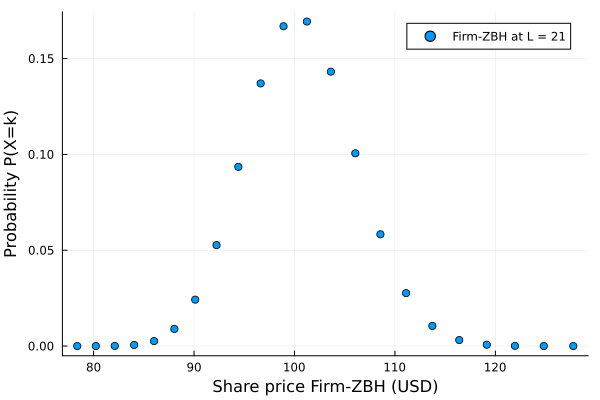

In [36]:
scatter(price_array,probability_array, label="Firm-$(random_firm_ticker) at L = $(L)")
xlabel!("Share price Firm-$(random_firm_ticker) (USD)", fontsize=18)
ylabel!("Probability P(X=k)", fontsize=18)

### TODO: Visualize binomial lattice simulation

In [38]:
levels = [k for k ∈ 0:(TSIM-1)]
expectation = 𝔼(random_test_model, levels; startindex = start_index);
variance = Var(random_test_model, levels; startindex = start_index);

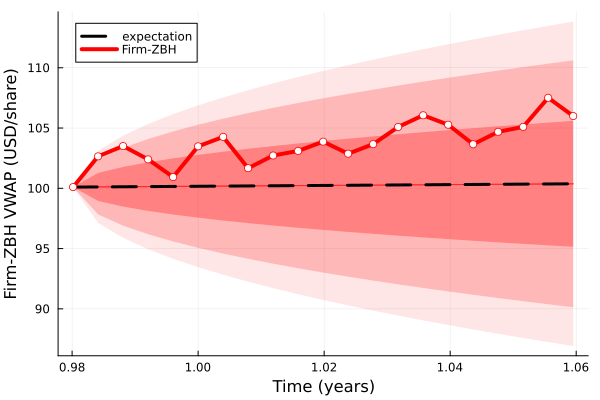

In [39]:
let 
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    T_range = range(start_index,stop=stop_index-1,step=1) |> collect 
    T_sim = T_range*Δt .- Δt

    plot(T_sim, expectation[:,2], fillrange=L68, c=:red, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=U68, c=:red, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=L95, c=:red, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2], fillrange=U95, c=:red, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2], fillrange=L99, c=:red, alpha=0.1, label="")
    plot!(T_sim, expectation[:,2], fillrange=U99, c=:red, alpha=0.1, label="")
    plot!(T_sim, expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price],  
        lw=4, c=:red, label="Firm-$(random_firm_ticker)", legend = :topleft)
    scatter!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price], label="", 
        msc=:red, mc=:white)

    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

The black dashed line is the expected share price predicted by the lattice model, while the shaded regions denote $\mu\pm{z}\cdot\sigma$ for $z=$`1.0,1.96,2.576`. The solid red line with circles is the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for this firm, and date range.

### Check: Was this a `successful` simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward, functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [42]:
let
    z = 2.576
    L = expectation[:,2] .- z*sqrt.(variance[:,2])
    U = expectation[:,2] .+ z*sqrt.(variance[:,2])
    
    # check the bounds: if below L, or above U then simulation failed
    success_flag = true;
    for k ∈ 1:TSIM
        
        price_value = random_firm_data[start_index+k-1,:volume_weighted_average_price];    
        if (price_value < L[k]) || (price_value > U[k])            
            success_flag = false;
            break;
        end
    end

    println("The simultion of the VWAP of Firm-$(random_firm_index) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simultion of the VWAP of Firm-457 between (248 -> 269) was successful: true


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.